# Image Registration

Here we use SimpleElastix to register the TP53 image against the H&E Image

**Resources:**
* [SimpleITK Notebooks](https://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/)

In [3]:
import glob
import io
from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np
import os
import openslide
from openslide import open_slide
import pandas as pd
from PIL import Image, ImageOps
import seaborn as sns
import SimpleITK as sitk
from skimage.color import rgb2hed
from skimage.exposure import histogram
from skimage.filters import threshold_otsu
from skimage import morphology
import time
import warnings

In [2]:
SLIDES_PATH = '/gpfs1/scratch/90days/s4436005'

In [3]:
#os.chdir('/Users/a.su/Documents/Stanford/Img_Registration')
#os.chdir('R:/Stanford_ColorectalCancer/A01_151219_svs')
os.chdir(SLIDES_PATH)
os.getcwd()

'/gpfs1/scratch/90days/s4436005'

In [4]:
#Find Slides in directory
slides = []
for infile in glob.glob('*.svs'):
    file, ext = os.path.splitext(infile)
    slides.append(infile)
slides.sort()
slides

['1820_N_10545A_2_HandE.svs',
 '1820_N_10545A_4_TP53.svs',
 '1820_T_105452F_2_HandE.svs',
 '1820_T_105452F_4_TP53.svs',
 '2065_N_12752A_2_HandE.svs',
 '2065_N_12752A_4_TP53.svs',
 '2065_T_12756A_2_HandE.svs',
 '2065_T_12756A_4_TP53.svs',
 '2112_N_12341B_2_HandE.svs',
 '2112_N_12341B_4_TP53.svs',
 '2112_T_12335F_2_HandE.svs',
 '2112_T_12335F_4_TP53.svs',
 '2148_N_11397A_2_HandE.svs',
 '2148_N_11397A_4_TP53.svs',
 '2148_T_11393A_2_HandE.svs',
 '2148_T_11393A_4_TP53.svs',
 '2171_N_11521A_2_HandE.svs',
 '2171_N_11521A_4_TP53.svs',
 '2171_T_11524A_2_HandE.svs',
 '2171_T_11524A_4_TP53.svs']

In [5]:
TP53_slides = [slide for slide in slides if 'TP53' in slide]
HE_slides = [slide for slide in slides if 'HandE' in slide]
Paired_slides = list(zip(TP53_slides, HE_slides))
Paired_slides

[('1820_N_10545A_4_TP53.svs', '1820_N_10545A_2_HandE.svs'),
 ('1820_T_105452F_4_TP53.svs', '1820_T_105452F_2_HandE.svs'),
 ('2065_N_12752A_4_TP53.svs', '2065_N_12752A_2_HandE.svs'),
 ('2065_T_12756A_4_TP53.svs', '2065_T_12756A_2_HandE.svs'),
 ('2112_N_12341B_4_TP53.svs', '2112_N_12341B_2_HandE.svs'),
 ('2112_T_12335F_4_TP53.svs', '2112_T_12335F_2_HandE.svs'),
 ('2148_N_11397A_4_TP53.svs', '2148_N_11397A_2_HandE.svs'),
 ('2148_T_11393A_4_TP53.svs', '2148_T_11393A_2_HandE.svs'),
 ('2171_N_11521A_4_TP53.svs', '2171_N_11521A_2_HandE.svs'),
 ('2171_T_11524A_4_TP53.svs', '2171_T_11524A_2_HandE.svs')]

In [6]:
tp53_slide = open_slide('2171_T_11524A_4_TP53.svs')
he_slide = open_slide('2171_T_11524A_2_HandE.svs')

In [7]:
def highest_mag(slide):
    """Returns the highest magnification for the slide
    """
    return int(slide.properties['aperio.AppMag'])

def level_mags(slide):
    """Returns the magnification for each level in a slide
    """
    return [highest_mag(slide)/downsample for downsample in slide.level_downsamples]

def get_level_size(slide, level):
    """Returns the dimensions of a level
    """
    return slide.level_dimensions[level]

def get_level_mag(slide, level):
    """Returns the magnification at a particular level
    """
    return level_mags(slide)[level]

def get_level_for_mag(slide, mag):
    """Get the level corresponding to a certain magnification, if available
    """
    level_mags_rounded = list(np.round(level_mags(slide), decimals = 2))
    if mag in level_mags_rounded:
        return level_mags_rounded.index(mag)
    else: 
        return None
    
def get_mag_for_size(slide, size):
    max_size = slide.dimensions
    max_mag = highest_mag(slide)
    downsample = np.average([max_dim/size_dim for max_dim, size_dim in zip(max_size, size)])
    return max_mag/downsample

def get_size_for_mag(slide, mag):
    max_size = slide.dimensions
    max_mag = highest_mag(slide)
    downsample = max_mag/mag
    return [np.int(np.round(dim/downsample)) for dim in max_size]

def read_slide_at_mag(slide, mag):
    exact_level = get_level_for_mag(slide, mag)
    if exact_level is not None:
        return slide.read_region((0,0), exact_level, get_level_size(slide, exact_level))
    else:
        max_size = slide.dimensions
        region_size = tuple(get_size_for_mag(slide, mag))
        downsample = np.average([max_dim/region_dim for max_dim, region_dim in zip(max_size, region_size)])
        best_level = slide.get_best_level_for_downsample(downsample)
        best_level_size = get_level_size(slide, best_level)
        best_level_img = slide.read_region((0,0), best_level, best_level_size)
        return best_level_img.resize(region_size, resample = Image.BICUBIC)   

In [8]:
#read_slide_at_mag(tp53_slide, 0.64)

In [9]:
#lst = list(np.round(level_mags(tp53_slide), decimals = 2))
#lst.index(20)

In [10]:
tuple(get_size_for_mag(tp53_slide, 10))

(33864, 21476)

### Image Registration

In [11]:
SLIDE_MAG = 4
he = read_slide_at_mag(he_slide, SLIDE_MAG)
tp53 = read_slide_at_mag(tp53_slide, SLIDE_MAG)

In [12]:
#Image.MAX_IMAGE_PIXELS = 1000000000
#tp53 = Image.open('2171_T_11524A_4_TP53_low.jpeg')
#he = Image.open('2171_T_11524A_4_HandE_low.jpeg')
#tp53_high = Image.open('2171_T_11524A_4_TP53_5x.jpeg')
#he_high = Image.open('2171_T_11524A_4_HandE_5x.jpeg')

In [13]:
def get_itk_from_pil(pil_img):
    return sitk.GetImageFromArray(np.array(pil_img))

def get_pil_from_itk(itk_img):
    return Image.fromarray(sitk.GetArrayFromImage(itk_img).astype(np.uint8))

def show_alignment_gray(fixed_img, moving_img, resize = None):
    blank_img = Image.new(('L'), fixed_img.size, color = 0)
    comparison = Image.merge('RGB', [moving_img, fixed_img, blank_img])
    if resize is None:
        return comparison
    else: 
        downsample = max(comparison.size)/resize
        final_size = tuple([np.int(np.round(dim/downsample)) for dim in comparison.size])
        return comparison.resize(final_size, resample = Image.BICUBIC)

In [14]:
def transform_rgb(rgb_img, transform_param_map, resize = None):
    r, g, b, = rgb_img.convert('RGB').split()
    transformix = sitk.TransformixImageFilter()
    transformix.SetTransformParameterMap(transform_param_map)
    transformed_channels = []
    for img in [r, g, b]:
        img_itk = get_itk_from_pil(img)
        transformix.SetMovingImage(img_itk)
        transformix.Execute()
        transformed_img = get_pil_from_itk(transformix.GetResultImage())
        transformed_channels.append(transformed_img)
    rgb_transformed = Image.merge('RGB', transformed_channels)
    if resize is None:
        return rgb_transformed
    else: 
        downsample = max(rgb_transformed.size)/resize
        final_size = tuple([np.int(np.round(dim/downsample)) for dim in rgb_transformed.size])
        return rgb_transformed.resize(final_size, resample = Image.BICUBIC)

In [15]:
tp53_gray = tp53.convert('L')
#tp53_gray

In [16]:
he_gray = he.convert('L')
#he_gray

In [17]:
tp53_itk = get_itk_from_pil(tp53_gray)
he_itk = get_itk_from_pil(he_gray)

In [18]:
#42.9 sec with RecusiveBSplines vs 43.7 sec with default settings

In [100]:
def elastix_params_for_mag(mag):
    a_param_map = sitk.GetDefaultParameterMap('affine')
    a_param_map['MaximumNumberOfIterations'] = [str(mag*512)]
    #a_param_map['NumberOfSpatialSamples'] = [str(mag**2*2048)]
    a_param_map['NumberOfSpatialSamples'] = ['2048']
    print('Number of Affine Spatial Samples: ', a_param_map['NumberOfSpatialSamples'])
    b_param_map = sitk.GetDefaultParameterMap('bspline')
    b_param_map['NumberOfResolutions'] = ['5']
    b_param_map['GridSpacingSchedule'] = ['6.6','4.0','2.6', '1.6', '1.0']
    b_param_map['Transform'] = ['RecursiveBSplineTransform']
    b_param_map['MaximumNumberOfIterations'] = [str(mag*1024)]
    print('Max BSpline Iterations: ', b_param_map['MaximumNumberOfIterations'])
    #b_param_map['NumberOfSpatialSamples'] = [str(mag**2*4096)]
    b_param_map['NumberOfSpatialSamples'] = ['4096']
    print('Number of BSpline Spatial Samples: ', b_param_map['NumberOfSpatialSamples'])
    #b_param_map['FinalGridSpacingInPhysicalUnits'] = [str((mag)*20)]
    b_param_map['FinalGridSpacingInPhysicalUnits'] = ['1080','540', '180', '60', '20']
    print('Final Grid Spacing in Physical Units: ', b_param_map['FinalGridSpacingInPhysicalUnits'])
    b_param_map['Metric'] = ['NormalizedMutualInformation']   #Faster with unnormalised version
    param_map_vector = sitk.VectorOfParameterMap()
    param_map_vector.append(a_param_map)
    param_map_vector.append(b_param_map)
    return param_map_vector

In [101]:
20*(3**4)

1620

In [102]:
fixed_img = he_itk
moving_img = tp53_itk
param_map = elastix_params_for_mag(SLIDE_MAG)

Number of Affine Spatial Samples:  ('2048',)
Max BSpline Iterations:  ('4096',)
Number of BSpline Spatial Samples:  ('4096',)
Final Grid Spacing in Physical Units:  ('1080', '540', '180', '60', '20')


In [103]:
for x in param_map:
    for y in x:
        print(y, x[y])

AutomaticParameterEstimation ('true',)
CheckNumberOfSamples ('true',)
DefaultPixelValue ('0.0',)
FinalBSplineInterpolationOrder ('3',)
FixedImagePyramid ('FixedSmoothingImagePyramid',)
ImageSampler ('RandomCoordinate',)
Interpolator ('LinearInterpolator',)
MaximumNumberOfIterations ('2048',)
MaximumNumberOfSamplingAttempts ('8',)
Metric ('AdvancedMattesMutualInformation',)
MovingImagePyramid ('MovingSmoothingImagePyramid',)
NewSamplesEveryIteration ('true',)
NumberOfResolutions ('4',)
NumberOfSamplesForExactGradient ('4096',)
NumberOfSpatialSamples ('2048',)
Optimizer ('AdaptiveStochasticGradientDescent',)
Registration ('MultiResolutionRegistration',)
ResampleInterpolator ('FinalBSplineInterpolator',)
Resampler ('DefaultResampler',)
ResultImageFormat ('nii',)
Transform ('AffineTransform',)
WriteIterationInfo ('false',)
WriteResultImage ('true',)
AutomaticParameterEstimation ('true',)
CheckNumberOfSamples ('true',)
DefaultPixelValue ('0.0',)
FinalBSplineInterpolationOrder ('3',)
FinalGr

In [104]:
print(sitk.PrintParameterMap(param_map))

None


This runs elastix and logs the output file. Note that this only logs the output file on the first run. 

In [105]:
start = time.time()

elastix = sitk.ElastixImageFilter()
elastix.SetFixedImage(fixed_img)
elastix.SetMovingImage(moving_img)
elastix.LogToFileOn()

elastix.SetParameterMap(param_map)
#elastix.LogToConsoleOn()
elastix.Execute()

result_img = elastix.GetResultImage()
transform_param_map = elastix.GetTransformParameterMap()

end = time.time()
print(end - start)

205.36124730110168


Registration Time <br>
* 1x = 40s

In [24]:
#tp53_aligned = transform_rgb(tp53, transform_param_map, resize = 1000)
#alignment2.convert('RGB').save('/gpfs1/scratch/90days/s4436005/img_reg/img_reg_comparison_inverted.jpeg', 'JPEG')

## Show Alignment

In [214]:
#############################
# Image Filtering Functions #
#############################

def filter_green_channel(img, g_thresh = 240):
    new_img = img.copy()
    pixels = new_img.load()
    for i in range(img.size[0]):   #For every column
        for j in range(img.size[1]):    #For every row
            if pixels[i,j][2] > g_thresh:
                pixels[i,j] = (255,255,255)
    return new_img        

def filter_green_fast(img, g_thresh = 240):
    #About 18x faster than previous implementation
    img = img.convert('RGB')
    r, g, b = img.split()
    green_mask = (np.array(g) > 240)*255
    green_mask_img = Image.fromarray(green_mask.astype(np.uint8), 'L')
    white_image = Image.new('RGB', img.size, (255,255,255))
    img_filtered = img.copy()
    img_filtered.paste(white_image, mask = green_mask_img)
    return img_filtered

def filter_grays(img, tolerance = 3):
    new_img = img.convert('RGB')
    pixels = new_img.load()
    for i in range(img.size[0]):
        for j in range(img.size[1]):
            r, g, b = pixels[i,j]
            rg_diff, rb_diff, gb_diff = abs(r-g) <= tolerance, abs(r-b) <= tolerance, abs(g-b) <= tolerance
            if rg_diff and rb_diff and gb_diff:
                pixels[i,j] = (255,255,255)
    return new_img

def filter_otsu_global(img, mode = 'PIL'):
    img_gray = img.convert('L')
    threshold = threshold_otsu(np.array(img_gray))
    img_binary = np.array(img_gray) > threshold
    if mode == '1':
        return img_binary
    else:
        return binary_array_to_pil(img_binary)

def binary_array_to_pil(array):
    img_shape = array.shape
    img = Image.new('1', img_shape)
    int_list = array.astype(int).tolist()
    pixels = img.load()
    for i in range(img.size[0]):
        for j in range(img.size[1]):
            pixels[i,j] = int_list[i][j]
    return ImageOps.mirror(img).rotate(90, expand = True) #Not sure why this is necessary

def white_pixels_to_black(img):
    new_img = img.convert('RGB')
    pixels = new_img.load()
    for i in range(img.size[0]):
        for j in range(img.size[1]):
            rgb = pixels[i,j]
            if rgb == (255,255,255):
                pixels[i,j] = (0,0,0)
    return new_img

def tile_gen(img, tile_size):
    '''Generates tiles for Pillow images
    '''
    width, height = img.size
    x_tiles = int(np.floor(width/tile_size))
    y_tiles = int(np.floor(height/tile_size))
    yield (x_tiles, y_tiles)
    for y in range(y_tiles):
        for x in range(x_tiles):
            x_coord = x*tile_size
            y_coord = y*tile_size
            yield img.crop((x_coord, y_coord, np.int(np.round(x_coord+tile_size)), np.int(np.round(y_coord+tile_size))))

In [193]:
#Filter grays faster
# This implementation isn't actually faster
start = time.time()
img = tp53_aligned_small
tolerance = 3
grays_mask = np.zeros(img.size[::-1])
pixels = img.load()
for i in range(img.size[0]):
    for j in range(img.size[1]):
        r, g, b = pixels[i,j]
        rg_diff, rb_diff, gb_diff = abs(r-g) <= tolerance, abs(r-b) <= tolerance, abs(g-b) <= tolerance
        if rg_diff and rb_diff and gb_diff:
            grays_mask[j,i] = 255
grays_mask_img = Image.fromarray(grays_mask.astype(np.uint8), 'L')
white_image = Image.new('RGB', img.size, (255,255,255))
img_filtered = img.copy()
img_filtered.paste(white_image, mask = grays_mask_img)
end = time.time()
print(end - start)

2.541149616241455


In [191]:
start = time.time()
filter_grays(tp53_aligned_small)
end = time.time()
print(end - start)

1.4453232288360596


In [188]:
65/2.6

25.0

In [186]:
img_array[0][0]

array([0, 0, 0], dtype=uint8)

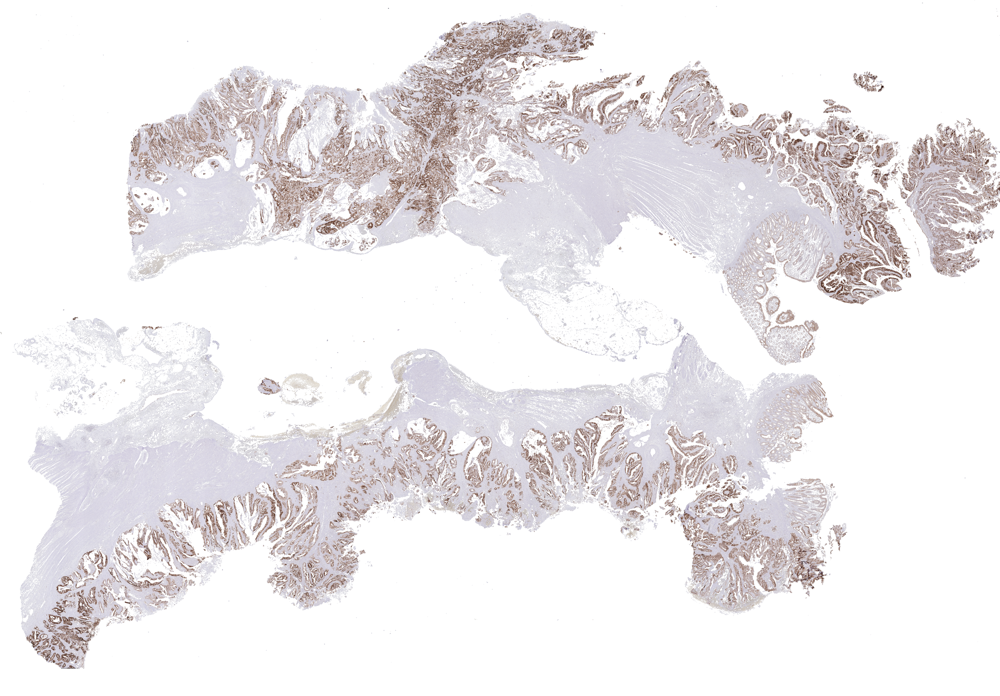

In [187]:
img_filtered.thumbnail((1000,1000))
img_filtered

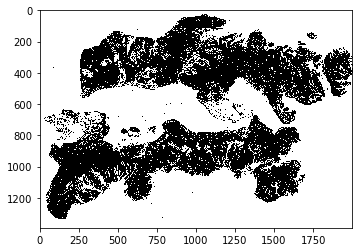

In [180]:
plt.imshow(grays_mask, cmap = 'gray')

In [106]:
start = time.time()
tp53_aligned = transform_rgb(tp53, transform_param_map)
end = time.time()
print(end - start)

43.910659074783325


In [334]:
start = time.time()
tp53_filtered = filter_green_fast(tp53_aligned)
he_filtered = filter_green_fast(he)
green_end = time.time()
tp53_filtered = filter_grays(tp53_filtered, tolerance = 3)
he_filtered = filter_grays(he, tolerance = 15)
gray_end = time.time()
print('Time to Filter Green: {0}'.format(green_end - start))
print('Time to Filter Gray: {0}'.format(gray_end - green_end))
# tp53_filtered_otsu = filter_otsu_global(tp53_filtered, 'PIL')

Time to Filter Green: 3.3407156467437744
Time to Filter Gray: 138.61315631866455


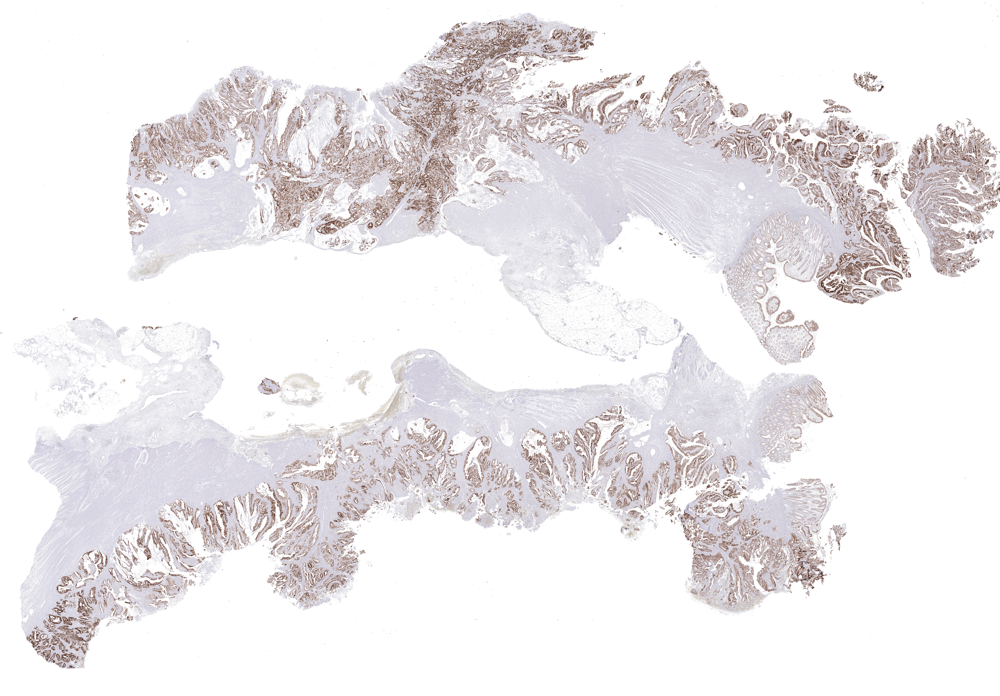

In [335]:
tp53_filtered_small = tp53_filtered.copy()
tp53_filtered_small.thumbnail((1000,1000))
tp53_filtered_small

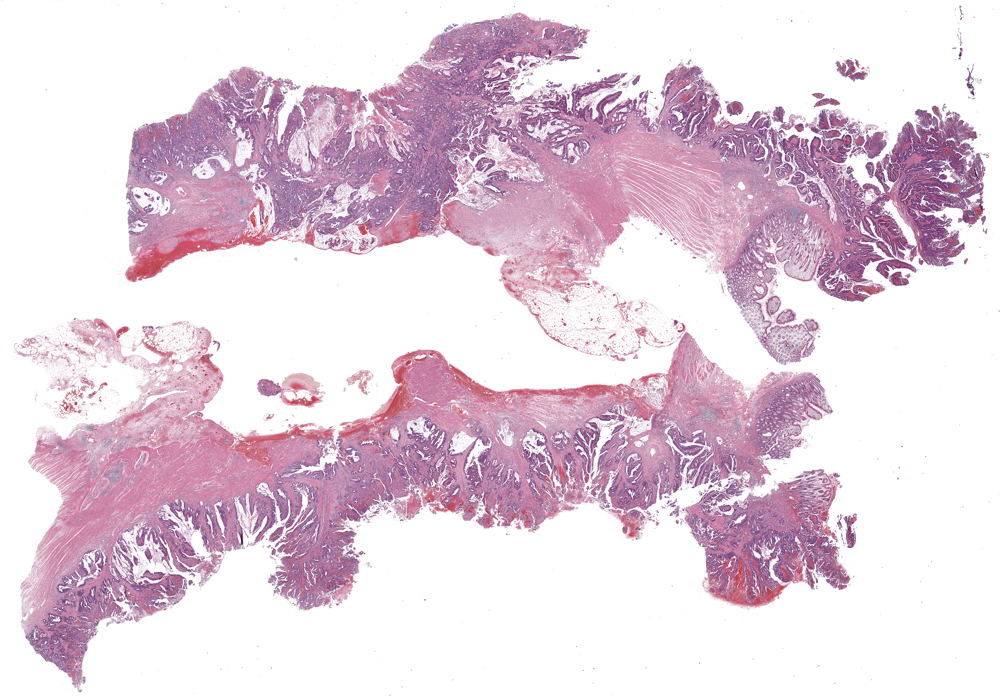

In [336]:
he_filtered_small = he_filtered.copy()
he_filtered_small.thumbnail((1000,1000))
he_filtered_small

In [28]:
# he_filtered = filter_green_channel(he)
# he_filtered = filter_grays(he_filtered, tolerance = 15)
# he_filtered_otsu = filter_otsu_global(he_filtered, 'PIL')

In [203]:
def show_alignment(fixed_img, moving_img, prefilter = None):
    if prefilter == 'TP53':
        tp53_filtered = filter_green_fast(moving_img)
        tp53_filtered = filter_grays(tp53_filtered, tolerance = 3)
        moving_img = filter_otsu_global(tp53_filtered, 'PIL')
        he_filtered = filter_green_fast(fixed_img)
        he_filtered = filter_grays(he_filtered, tolerance = 15)
        fixed_img = filter_otsu_global(he_filtered, 'PIL')
    background = (255,255,255)
    img_red = ImageOps.colorize(moving_img.convert('L'), (255, 0, 0), background)
    img_blue = ImageOps.colorize(fixed_img.convert('L'), (0, 0, 255), background)
    img_red.putalpha(120)
    img_blue.putalpha(70)
    return Image.alpha_composite(img_red, img_blue)

In [216]:
he_small = he.copy()
he_small.thumbnail((2000,2000))
tp53_aligned_small = tp53_aligned.copy()
tp53_aligned_small.thumbnail((2000, 2000))

In [217]:
start = time.time()
comparison = show_alignment(he_small, tp53_aligned_small, prefilter = 'TP53')
end = time.time()

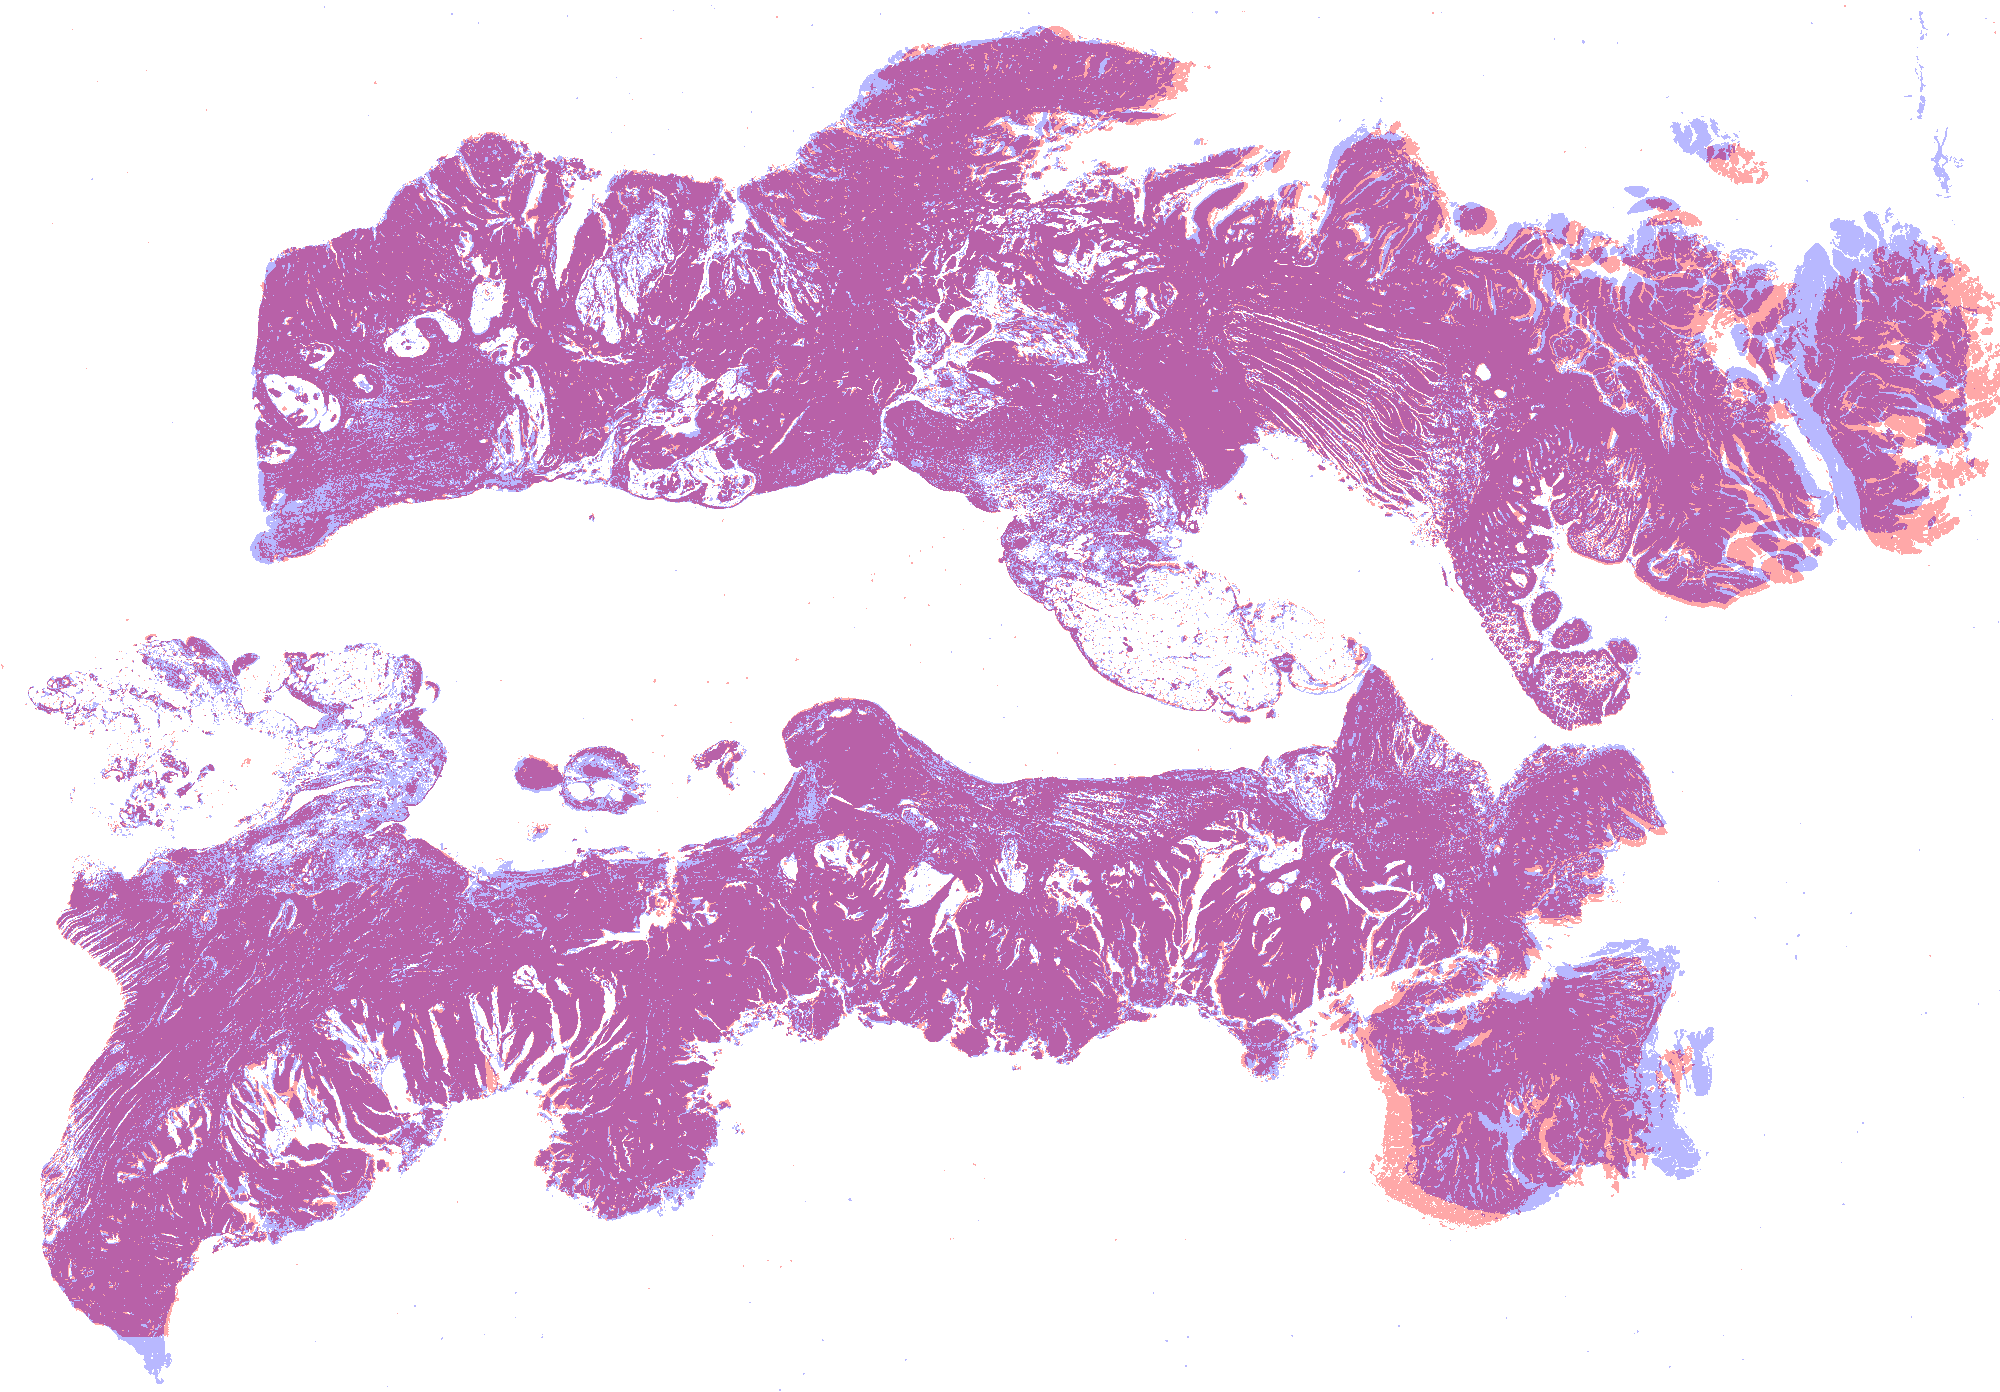

In [218]:
comparison

In [45]:
# comparison.convert('RGB').save('/gpfs1/scratch/90days/s4436005/img_reg/img_reg_comparsion_red_blue.jpeg', 'JPEG')

## Discard Poorly Registered Regions

### Calculate Mutual Information Metric
<br>
Resource: https://matthew-brett.github.io/teaching/mutual_information.html

In [ ]:
fixed_np = np.array(get_pil_from_itk(fixed_img))

In [ ]:
result_np = np.array(get_pil_from_itk(result_img))

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(np.hstack((fixed_pil, result_pil)), cmap = 'gray')

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (10,5))
ax[0].hist(fixed_np.ravel(), bins = 20)
ax[0].set_title('Fixed (H&E) Image Histogram')
ax[1].hist(result_np.ravel(), bins = 20)
ax[1].set_title('Result (TP53) Image Histogram')

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(fixed_np.ravel(), result_np.ravel(), '.')
#plt.xlabel('Fixed (H&E) Image')
#plt.ylabel('Result (TP53) Image')
#plt.title('Fixed vs Result Image')

In [ ]:
np.corrcoef(fixed_np.ravel(), result_np.ravel())[0,1]

In [ ]:
hist_2d, x_edges, y_edges = np.histogram2d(fixed_np.ravel(), result_np.ravel(), bins = 20)
plt.imshow(hist_2d.T, origin = 'lower')
plt.xlabel('Fixed Image bin')
plt.ylabel('Result Image bin')

In [ ]:
# Show log histogram, avoiding divide by 0
hist_2d_log = np.zeros(hist_2d.shape)
non_zeros = hist_2d != 0
hist_2d_log[non_zeros] = np.log(hist_2d[non_zeros])
plt.imshow(hist_2d_log.T, origin = 'lower')
plt.xlabel('Fixed Image bin')
plt.ylabel('Result Image bin')

In [33]:
################################
# Mutual Information Functions #
################################

def mutual_information(hgram):
    """Mutual information for joint histogram
    """
    # Convert bins counts to probability values
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis = 1) # marginal for x over y
    py = np.sum(pxy, axis = 0) # marginal for y over x
    px_py = px[:, None] * py[None, :] #Broadcat to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays 
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

def mutual_info_histogram(fixed_img, moving_img, log = False):
    hist_2d, x_edges, y_edges = np.histogram2d(fixed_img.ravel(), moving_img.ravel(), bins = 20)
    if log:
        hist_2d_log = np.zeros(hist_2d.shape)
        non_zeros = hist_2d != 0
        hist_2d_log[non_zeros] = np.log(hist_2d[non_zeros])
        return hist_2d_log
    return hist_2d

def plot_mutual_info_histogram(histogram):
    plt.imshow(histogram.T, origin = 'lower')
    plt.xlabel('Fixed Image')
    plt.ylabel('Moving Image')
    
def calculate_mutual_info(fixed_img, moving_img):
    hist = mutual_info_histogram(fixed_img, moving_img)
    return mutual_information(hist)

In [ ]:
mutual_information(hist_2d)

In [ ]:
result_moved = np.zeros(result_np.shape)
result_moved[100:, :] = result_np[:-100, :]
plt.imshow(np.hstack((fixed_np, result_moved)))

In [ ]:
hist_2d_moved, x_edges, y_edges = np.histogram2d(fixed_np.ravel(), result_moved.ravel(), bins = 20)
hist_2d_moved_log = np.zeros(hist_2d_moved.shape)
non_zeros = hist_2d_moved != 0
hist_2d_moved_log[non_zeros] = np.log(hist_2d_moved[non_zeros])
plt.imshow(hist_2d_moved_log.T, origin = 'lower')
plt.xlabel('Fixed Image')
plt.ylabel('Result Image')

In [ ]:
mutual_information(hist_2d_moved)

In [ ]:
hist = mutual_info_histogram(fixed_np, result_np, log = True)
plot_mutual_info_histogram(hist)

In [ ]:
calculate_mutual_info(fixed_np, result_np)

### Calculate and  Visualise Mutual Information for each tile

In [34]:
TILE_MAG = 10
tile_size = 299*SLIDE_MAG/TILE_MAG
tp53_tgen = tile_gen(transform_rgb(tp53, transform_param_map), tile_size)
he_tgen = tile_gen(he, tile_size)

In [35]:
tp53_tiles = list(tp53_tgen)
he_tiles = list(he_tgen)

In [36]:
len(tp53_tiles)

8285

In [37]:
all_tiles = [[tp53_tiles[i], he_tiles[i]] for i in range(1, len(tp53_tiles)) ]

In [38]:
def mutual_info_tiles(paired_tile):
    tp53_tile = paired_tile[0].convert('RGB')
    he_tile = paired_tile[1].convert('RGB')
    tp53_tile_np = np.array(tp53_tile)
    he_tile_np = np.array(he_tile)
    fig, ax = plt.subplots(2, 1, figsize = (10,10))
    ax[0].imshow(np.hstack((tp53_tile_np, he_tile_np)))
    tp53_tile_np_gray = np.array(tp53_tile.convert('L'))
    he_tile_np_gray = np.array(he_tile.convert('L'))
    hist = mutual_info_histogram(he_tile_np_gray, tp53_tile_np_gray, log = True)
    ax[1].imshow(hist)
    print('mutual information: {0}'.format(calculate_mutual_info(he_tile_np_gray, tp53_tile_np_gray)))

In [39]:
interact(lambda x: mutual_info_tiles(all_tiles[x]), x=(1, len(tp53_tiles)));

interactive(children=(IntSlider(value=4143, description='x', max=8285, min=1), Output()), _dom_classes=('widge…

In [229]:
def mutual_info_array(paired_tiles, shape):
    array = []
    for paired_tile in paired_tiles:
        tp53_tile = paired_tile[0].convert('L')
        he_tile = paired_tile[1].convert('L')
        tp53_tile_np = np.array(tp53_tile)
        he_tile_np = np.array(he_tile)
        mutual_info = calculate_mutual_info(he_tile_np, tp53_tile_np)
        array.append(mutual_info)
    return np.reshape(array, shape)

In [230]:
mi_array = mutual_info_array(all_tiles, shape = tp53_tiles[0])

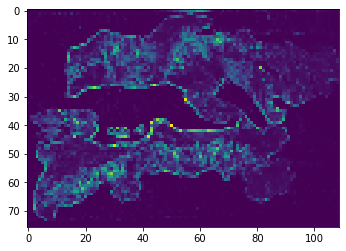

In [231]:
show_mask(mi_array)

In [260]:
min(mi_array.ravel())

-2.220446049250314e-16

In [221]:
def ncc_info_array(paired_tiles, shape):
    array = []
    for paired_tile in paired_tiles:
        tp53_tile = paired_tile[0].convert('L')
        he_tile = paired_tile[1].convert('L')
        tp53_tile_np = np.array(tp53_tile)
        he_tile_np = np.array(he_tile)
        corrcoef = np.corrcoef(he_tile_np.ravel(), tp53_tile_np.ravel())[0,1]
        array.append(corrcoef)
    return np.reshape(array, shape)

In [223]:
ncc_array = ncc_info_array(all_tiles, shape = tp53_tiles[0])

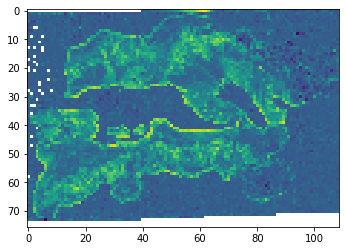

In [228]:
show_mask(ncc_array)

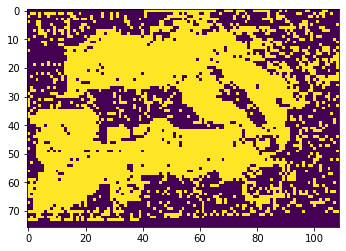

In [256]:
show_mask(np.nan_to_num(ncc_array)> 0.02)

### Mask off Cancer and Normal Areas

In [225]:
##################
# Mask Functions #
##################

def threshold_otsu_masked(hed_img):
    """Otsu thresholds the DAB component of an image
       Masks the background so only tissue regions are used for threshold calculation
    """
    dab = -hed_img[:, :, 2]
    hem = -hed_img[:,:, 0]
    hem_thresh = threshold_otsu(hem)
    hem_binary_otsu = hem > hem_thresh
    #Use binary mask to mask out background of DAB images
    dab_masked = np.where(hem_binary_otsu == False, dab, 0)
    dab_values = np.array([i for i in dab_masked.ravel() if i != 0])
    #Otsu Thresholding
    hist, bin_centers = histogram(dab_values, 256)
    hist = hist.astype(float)
    # class probabilities for all possible thresholds
    weight1 = np.cumsum(hist)
    weight2 = np.cumsum(hist[::-1])[::-1]
    # class means for all possible thresholds
    mean1 = np.cumsum(hist * bin_centers) / weight1
    mean2 = (np.cumsum((hist * bin_centers)[::-1]) / weight2[::-1])[::-1]
    # Clip ends to align class 1 and class 2 variables:
    # The last value of `weight1`/`mean1` should pair with zero values in
    # `weight2`/`mean2`, which do not exist.
    variance12 = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2
    idx = np.argmax(variance12)
    #Consider all cells are normal if variance is too small
    if variance12[idx] < 500000:
        threshold = 0
    else:
        threshold = bin_centers[:-1][idx]
    return threshold

def ihc2gray(img):
    """Converts binary images to grayscale image
    """
    img_rescaled = (img*255).astype('uint8')
    return Image.fromarray(img_rescaled).convert('L')
            
def cancer_mask(img, tile_size, cancer_thresh):
    #Determine Dab threshold with a smaller 1000x1000 image
    downsample = max(img.size)/1000
    img_small_size = tuple([np.int(np.round(dim/downsample)) for dim in img.size])
    img_small = img.resize(img_small_size, resample = Image.BICUBIC)
    hed_small = rgb2hed(img_small)
    dab_thresh = threshold_otsu_masked(hed_small)
    mask = []
    tgen = tile_gen(img, tile_size)
    shape = next(tgen)
    for tile in tgen:
        tile = tile.convert('RGB')
        tile_hed = rgb2hed(tile)
        tile_dab = -tile_hed[:,:,2]
        binary_dab = tile_dab > dab_thresh
        if np.array(ihc2gray(binary_dab)).mean() < cancer_thresh:
            mask.append(0)
        else:
            mask.append(1)
    return np.reshape(mask, shape)  

def threshold_mask(tile_gen, threshold):
    """Creates mask from tiles using a threshold
    """
    mask = []
    shape = next(tile_gen)
    for tile in tile_gen:
        if np.array(tile).mean() < threshold:
            mask.append(0)
        else:
            mask.append(1)
    return np.reshape(mask, shape)

In [310]:
def mi_threshold_otsu(mi_array):
    #Otsu Thresholding
    hist, bin_centers = histogram(mi_array.ravel(), 256)
    hist = hist.astype(float)
    # class probabilities for all possible thresholds
    weight1 = np.cumsum(hist)
    weight2 = np.cumsum(hist[::-1])[::-1]
    # class means for all possible thresholds
    mean1 = np.cumsum(hist * bin_centers) / weight1
    mean2 = (np.cumsum((hist * bin_centers)[::-1]) / weight2[::-1])[::-1]
    # Clip ends to align class 1 and class 2 variables:
    # The last value of `weight1`/`mean1` should pair with zero values in
    # `weight2`/`mean2`, which do not exist.
    variance12 = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2
    idx = np.argmax(variance12)
    return bin_centers[:-1][idx], mean1[idx], mean2[idx]

In [311]:
from skimage.filters import threshold_otsu

In [344]:
non_zeros = mi_array > 0
mi_threshold_log, mean1, mean2 = mi_threshold_otsu(np.log10(mi_array[non_zeros]))
print(mi_threshold_log, mean1, mean2)
mi_threshold = 10**(mi_threshold_log)
print(mi_threshold)

-2.0890780751873805 -2.894730479358465 -1.2488932789243008
0.008145578339160053


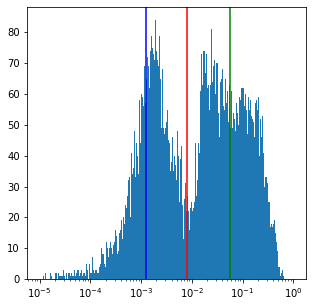

In [345]:
logbins = np.logspace(np.log10(0.00001), np.log10(1), 256)
fig, ax = plt.subplots(figsize = (5,5))
ax.hist(mi_array.ravel(), bins = logbins)
ax.set_xscale('log')
ax.axvline(mi_threshold, color='r')
ax.axvline(10**mean1, color = 'b')
ax.axvline(10**mean2, color = 'g')

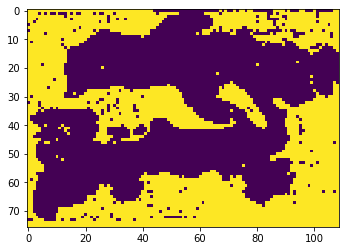

In [346]:
mi_mask = mi_array < mi_threshold
show_mask(mi_mask)

In [324]:
ncc_array_clean = np.nan_to_num(ncc_array)
ncc_threshold = threshold_otsu(ncc_array_clean.ravel())
ncc_threshold

0.20261780855386113

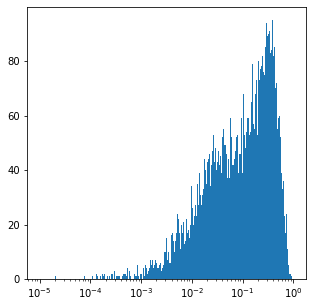

In [331]:
logbins = np.logspace(np.log10(0.00001), np.log10(1), 256)
fig, ax = plt.subplots(figsize = (5,5))
non_zero = ncc_array_clean != 0
ax.hist(ncc_array_clean[non_zero].ravel(), bins = logbins)
ax.set_xscale('log')

In [273]:
def show_mask(mask):
    return plt.imshow(np.reshape(mask, mask.shape[::-1]))

def plot_mask(tile_gen, tile_size, background_mask, fill = 'red'):
    w, h = tile_size
    x_tiles, y_tiles = next(tile_gen)
    tiled = Image.new('RGB', (w*x_tiles, h*y_tiles))
    i = 0
    for y in range(y_tiles):
        for x in range(x_tiles):
            if background_mask.ravel()[i] == 0:
                colour = fill
            else:
                colour = 'grey'
            tile_border = add_border(next(tile_gen), round(w*0.03), fill = colour)
            tiled.paste(tile_border, (x*w, y*h))
            i += 1
    return tiled

def add_border(img, width, fill):
    w, h = img.size
    img = img.crop((width, width, w-width, h-width))
    img_bordered = ImageOps.expand(img, width, fill = fill)
    return img_bordered

def plot_masks(tile_gen, tile_size, tissue_mask, cancer_mask, fill = 'red', uncertain_mask = None):
    """Plots the tiles as a single image with a red border for cancer tiles and a green border for normal tiles
    """
    w, h = tile_size
    x_tiles, y_tiles = next(tile_gen)
    tiled = Image.new('RGB', (w*x_tiles, h*y_tiles))
    i = 0
    for y in range(y_tiles):
        for x in range(x_tiles):
            if cancer_mask.ravel()[i] == 0:
                colour = fill
            elif uncertain_mask is not None and uncertain_mask.ravel()[i] == 0:
                colour = 'orange'
            elif tissue_mask.ravel()[i] == 0:
                colour = 'lime'
            else:
                colour = 'silver'
            tile_border = add_border(next(tile_gen), int(np.ceil(w*0.03)), fill = colour)
            tiled.paste(tile_border, (x*w, y*h))
            i += 1
    return tiled

In [75]:
def downscale_img(img, downscale_factor):
    x, y = img.size
    new_x, new_y = int(round(x/downscale_factor)), int(round(y/downscale_factor))
    return img.resize((x, y), Image.BICUBIC)

In [76]:
tp53_aligned_small = downscale_img(tp53_aligned, 10)

In [ ]:
tp53_aligned_small

In [78]:
# Plot areas with poor registration
#tgen = tile_gen(he, TILE_SIZE)
#tgen = tile_gen(comparison, tile_size)
tile_size_small = tile_size/10
tgen = tile_gen(tp53_aligned_small, tile_size_small)
plot_mask(tgen, (int(round(tile_size_small)),int(round(tile_size_small))), mi_mask, fill = 'red')

IndexError: index 2052 is out of bounds for axis 0 with size 2052

In [333]:
#Generate cancer mask and tissue mask from filtered tp53 image
c_mask = cancer_mask(tp53_filtered, tile_size, 250)
tgen = tile_gen(tp53_filtered, tile_size)
t_mask_tp53 = threshold_mask(tgen, 250)

In [337]:
tgen = tile_gen(he_filtered, tile_size)
t_mask_he = threshold_mask(tgen, 250)

In [ ]:
tgen = tile_gen(tp53_filtered, tile_size)
tile_size_int = np.int(np.round(tile_size))
#plot_mask(tgen, (tile_size_int, tile_size_int), c_mask)
picture = plot_masks(tgen, (tile_size_int, tile_size_int), mi_array < 0.03, c_mask)


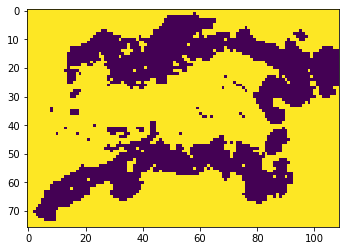

In [265]:
show_mask(c_mask)

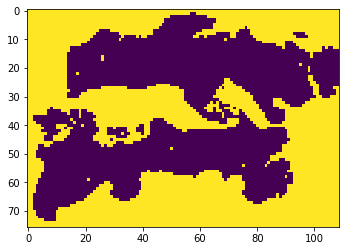

In [338]:
show_mask(t_mask_tp53)

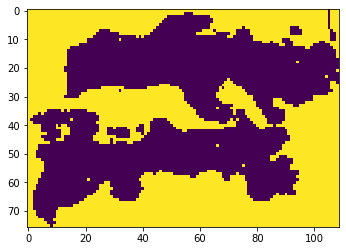

In [339]:
show_mask(t_mask_he)

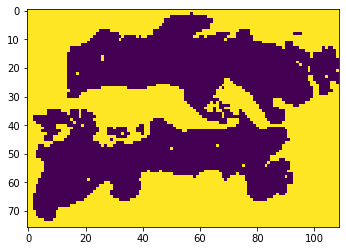

In [347]:
t_mask = np.logical_not(np.logical_not(t_mask_tp53) & np.logical_not(t_mask_he))
show_mask(t_mask)

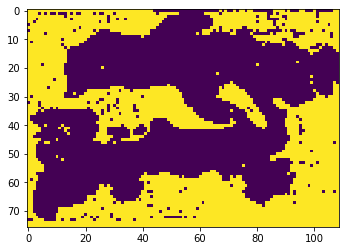

In [348]:
show_mask(mi_mask)

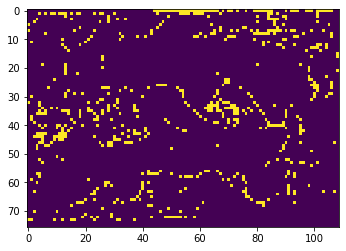

In [351]:
show_mask(np.bitwise_xor(t_mask, mi_mask))

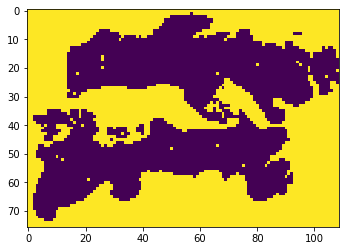

In [352]:
t_mask_filtered = np.logical_not(np.logical_not(t_mask) & np.logical_not(mi_mask))
#t_mask_filtered = t_mask_filtered > 0
show_mask(t_mask_filtered)

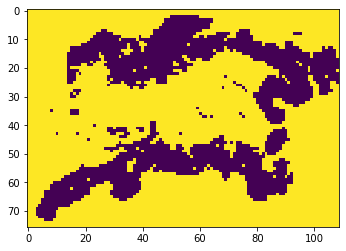

In [353]:
c_mask_filtered = np.logical_not(np.logical_not(c_mask) & np.logical_not(t_mask_filtered))
show_mask(c_mask_filtered)

In [299]:
min(c_mask_filtered.ravel())

False

In [354]:
# Overlay masks onto H&E Image
tgen = tile_gen(he, tile_size)
tile_size_int = np.int(np.round(tile_size))
he_overlay = plot_masks(tgen, (tile_size_int, tile_size_int), t_mask_filtered, c_mask_filtered)
#he_overlay = plot_mask(tgen, (tile_size_int, tile_size_int), c_mask_filtered)
he_overlay_name = 'he_overlay_' + str(TILE_MAG) + 'x.jpeg'
he_overlay.convert('RGB').save('/gpfs1/scratch/90days/s4436005/img_reg/' + he_overlay_name, 'JPEG')

In [355]:
# Overlay masks on aligned TP53 Image
tgen = tile_gen(tp53_aligned, tile_size)
tp53_aligned_overlay = plot_masks(tgen, (tile_size_int, tile_size_int), t_mask_filtered, c_mask_filtered)
tp53_aligned_overlay_name = 'tp53_aligned_overlay_' + str(TILE_MAG) + 'x.jpeg'
tp53_aligned_overlay.convert('RGB').save('/gpfs1/scratch/90days/s4436005/img_reg/' + tp53_aligned_overlay_name, 'JPEG')

In [357]:
# Overlay onto comparison Image
comparison = show_alignment(he_filtered, tp53_filtered)
tgen = tile_gen(comparison, tile_size)
comparison_overlay = plot_masks(tgen, (tile_size_int, tile_size_int), t_mask_filtered, c_mask_filtered)
comparison_overlay_name = 'registration_comparison_overlay_' + str(TILE_MAG) + 'x.jpeg'
comparison_overlay.convert('RGB').save('/gpfs1/scratch/90days/s4436005/img_reg/' + comparison_overlay_name, 'JPEG')

In [ ]:
# tp53_filtered.save('/gpfs1/scratch/90days/s4436005/img_reg/tp53_white_background.jpeg', 'JPEG')

In [ ]:
white_pixels_to_black(tp53_filtered)

In [ ]:
tp53_filtered2 = morphology.remove_small_holes(tp53_filtered_otsu, area_threshold = 0, connectivity = 100)

In [ ]:
# tp53_filtered_otsu.save('/gpfs1/scratch/90days/s4436005/img_reg/tp53_tissue_thresholded.jpeg', 'JPEG')

In [ ]:
ImageOps.invert(filter_otsu_global(tp53_filtered).convert('L'))

In [ ]:
img_otsu.shape

In [ ]:
tp53_filtered.size